In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:

# Generate synthetic data
# Assuming you have V, A, B, and C as inputs and outputs
V = torch.rand(100, 1)  # 100 samples of V
A = 2 * V**3 + 0.1*torch.rand(100, 1)  # Some function of V for A
B = torch.zeros(100, 1)  # Initialize B with zeros (unknown)  
C = torch.zeros(100, 1)  # Initialize C with zeros (unknown)

Epoch 0/15000, Total Loss: 0.5172072052955627
Epoch 100/15000, Total Loss: 0.4068722724914551
Epoch 200/15000, Total Loss: 0.3631803095340729
Epoch 300/15000, Total Loss: 0.3463135361671448
Epoch 400/15000, Total Loss: 0.33589470386505127
Epoch 500/15000, Total Loss: 0.328158974647522
Epoch 600/15000, Total Loss: 0.32210269570350647
Epoch 700/15000, Total Loss: 0.31703752279281616
Epoch 800/15000, Total Loss: 0.31239965558052063
Epoch 900/15000, Total Loss: 0.30768075585365295
Epoch 1000/15000, Total Loss: 0.3023746609687805
Epoch 1100/15000, Total Loss: 0.29593604803085327
Epoch 1200/15000, Total Loss: 0.2877539396286011
Epoch 1300/15000, Total Loss: 0.2771390676498413
Epoch 1400/15000, Total Loss: 0.26333296298980713
Epoch 1500/15000, Total Loss: 0.24558205902576447
Epoch 1600/15000, Total Loss: 0.22334589064121246
Epoch 1700/15000, Total Loss: 0.19668704271316528
Epoch 1800/15000, Total Loss: 0.16675929725170135
Epoch 1900/15000, Total Loss: 0.13600558042526245
Epoch 2000/15000, Tot

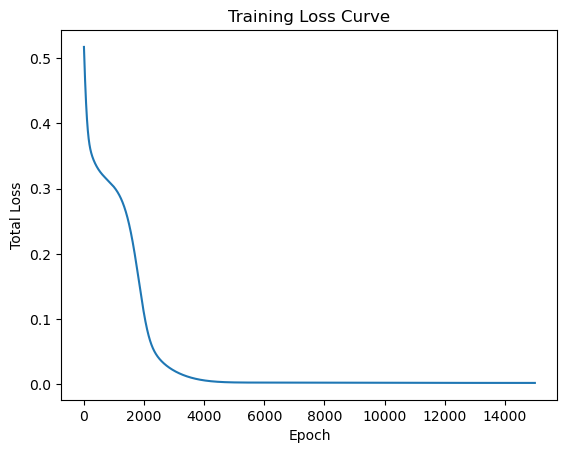

In [3]:
# Create a deep neural network with constraints on B and C
class DeepModel(nn.Module):
    def __init__(self):
        super(DeepModel, self).__init__()
        self.fc1 = nn.Linear(1, 64)  # Input to first hidden layer
        self.fc2 = nn.Linear(64, 32)  # First hidden layer to second hidden layer
        self.fc3 = nn.Linear(32, 16)  # Second hidden layer to third hidden layer
        self.fc4_A = nn.Linear(16, 1)  # Third hidden layer to output layer for A
        self.fc4_B = nn.Linear(16, 1)  # Third hidden layer to output layer for B
        self.fc4_C = nn.Linear(16, 1)  # Third hidden layer to output layer for C

        # Sigmoid activation function for B and C to squash values to [0, 1]
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Apply activation functions (e.g., ReLU) between hidden layers
        x = nn.functional.sigmoid(self.fc1(x))
        x = nn.functional.sigmoid(self.fc2(x))
        x = nn.functional.sigmoid(self.fc3(x))
        
        # Separate linear layers for each output
        output_A = self.fc4_A(x)
        output_B = self.sigmoid(self.fc4_B(x)) * 2 + 1  # Map to [0, 1]
        output_C = self.sigmoid(self.fc4_C(x)) * 2 + 1  # Map to [0, 3]
        return output_A, output_B, output_C

# Instantiate the model
model = DeepModel()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
epochs = 15000
losses = []  # To store the loss for plotting

for epoch in range(epochs):
    # Forward pass
    output_A, output_B, output_C = model(V)

    # Calculate the loss for each output
    loss_A = criterion(output_A, A)
    loss_BC = criterion(output_B*V**output_C, A)
    # loss_B = criterion(output_B, B)
    # loss_C = criterion(output_C, C)
    
    # Total loss is the sum of individual losses
    loss = loss_A+ loss_BC #+ loss_B + loss_C

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Store the total loss for later plotting
    losses.append(loss.item())

    # Print the loss every 100 epochs
    if epoch % 100 == 0:
        print(f'Epoch {epoch}/{epochs}, Total Loss: {loss.item()}')

# After training, you can use the model to make predictions
A_pred, B_pred, C_pred = model(V)

# Plot the loss curve
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Training Loss Curve')
plt.show()



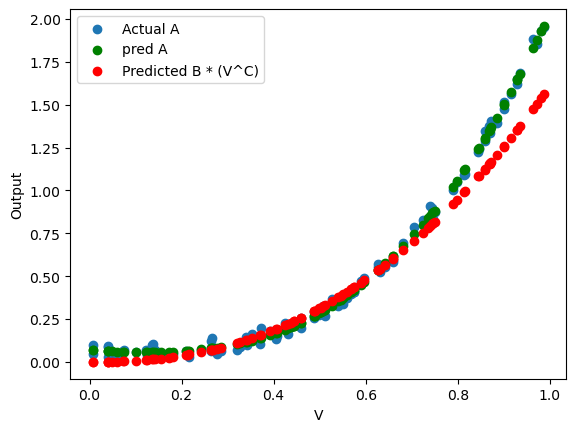

In [4]:
# Convert torch tensors to NumPy arrays for plotting
V_np = V.detach().numpy()
A_np = A.detach().numpy()
A_pred_np = A_pred.detach().numpy()
B_pred_np = B_pred.detach().numpy()
C_pred_np = C_pred.detach().numpy()

# Scatter plot of V and A
plt.scatter(V_np, A_np, label='Actual A')
plt.scatter(V_np, A_pred_np, label='pred A', color='green')

# plt.scatter(V.detach().numpy(), B.detach().numpy(), label='Actual B')
# plt.scatter(V.detach().numpy(), C.detach().numpy(), label='Actual C')

# Use the predicted values of B and C to compute the predicted relationship B * (V^C)
predicted_B = B_pred.detach().numpy()
predicted_C = C_pred.detach().numpy()

predicted_relationship = predicted_B.mean() * (V.detach().numpy()**predicted_C.mean())

plt.scatter(V.detach().numpy(), predicted_relationship, color='red', label='Predicted B * (V^C)')

plt.xlabel('V')
plt.ylabel('Output')
plt.legend()
plt.show()